In [2]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d.io import get_tif_tag
from suite3d.io import tiff_utils as tfu
from suite3d import file_utils as flu
import colorcet

from suite3d import nbtools as nbui

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
job3d = Job('/mnt/md0/runs','SS003_2024-08-06_2', create=False)
# job2d = Job('/mnt/md0/runs','SS003_2024-08-06_2_2DREG', create=False)
# job2d = Job('/mnt/md0/runs','SS003_2024-08-06_2_2DREG_SHALLOWER', create=False)
# dmov3d = job3d.get_registered_movie()[8:17]
job2d = Job('/mnt/md0/runs','SS003_2024-08-06_2_2DREG_FULL', create=False)
dmov3d = job3d.get_registered_movie()
dmov2d = job2d.get_registered_movie()

   Found and loaded params from /mnt/md0/runs/s3d-SS003_2024-08-06_2/params.npy
   Found and loaded params from /mnt/md0/runs/s3d-SS003_2024-08-06_2_2DREG_FULL/params.npy


In [4]:
reg3d = job3d.load_registration_results()

sh3 = n.concatenate(reg3d['sub_pixel_shifts'],axis=0)[:2100]
sh3x = n.concatenate(reg3d['int_shift'])[:2100,2]
sh3y = n.concatenate(reg3d['int_shift'])[:2100,1]

reg2d = job2d.load_registration_results()
sh2xs = n.concatenate(reg2d['xmaxs_rr'])
sh2ys = n.concatenate(reg2d['ymaxs_rr'])

In [5]:
reg2d.keys()

dict_keys(['xmaxs_rr', 'ymaxs_rr', 'xmaxs_nr', 'ymaxs_nr', 'metrics'])

In [6]:
shxall = n.concatenate([sh3x[:,n.newaxis], sh2xs],axis=1)
shyall = n.concatenate([sh3y[:,n.newaxis], sh2ys],axis=1)

In [7]:
shx_corrs = n.corrcoef(shxall.T)
shy_corrs = n.corrcoef(shyall.T)

In [8]:
all_diffs = []
for pidx in range(22):
    diffs = (sh2xs[:,pidx] - sh2xs.mean(axis=1))
    diffs = diffs - diffs.mean()
    all_diffs.append(diffs)

In [9]:
all_diffs = n.array(all_diffs)

In [10]:
sh2xvar = sh2xs.var(axis=1)

In [11]:
sh2xvar_pct = n.percentile(sh2xvar, 95)
sh2xvar_pct_low = n.percentile(sh2xvar, 50)
var_idxs = n.nonzero(sh2xvar > sh2xvar_pct)
nvar_idxs = n.nonzero(sh2xvar <= sh2xvar_pct_low)

In [125]:
%%time
nt = 2100
dyx = (-1,1)
# pidx = 10
pidx = 4
ylim = (300,450)
xlim = (300, 450)
mov2 = dmov2d[pidx,:nt, ylim[0]-dyx[0]:ylim[1]-dyx[0], xlim[0]-dyx[1]:xlim[1]-dyx[1]].compute()
mov3 = dmov3d[pidx,:nt, ylim[0]:ylim[1], xlim[0]:xlim[1]].compute()

CPU times: user 1min 53s, sys: 1min, total: 2min 53s
Wall time: 10.9 s


In [126]:
imvar3 = mov3[var_idxs].mean(axis=0)
imvar2 = mov2[var_idxs].mean(axis=0)

In [127]:
im3 = mov3.mean(axis=0)
im2 = mov2.mean(axis=0)

(None, <Axes: >, <matplotlib.image.AxesImage at 0x7f3bd74b4400>)

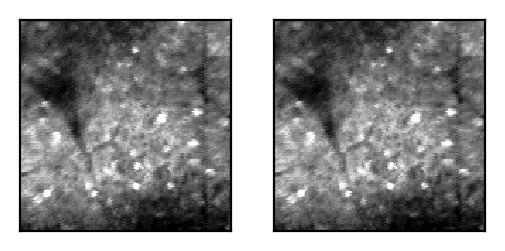

In [128]:
f,axs =plt.subplots(1,2, figsize=(3,6), dpi=200)
tfu.show_tif(im3,ax=axs[0])
tfu.show_tif(im2,ax=axs[1])

In [129]:
from suite3d import quality_metrics as qm

In [130]:
noise2 = qm.shot_noise_pct(mov2.reshape(nt,-1).T, job2d.params['fs'])
noise3 = qm.shot_noise_pct(mov3.reshape(nt,-1).T, job3d.params['fs'])

Text(0, 0.5, 'Standardized Shot Noise per Pixel\nwith 3D Registration')

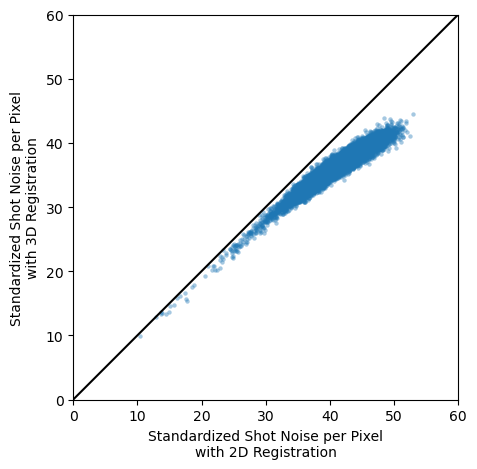

In [134]:
f,ax = plt.subplots(1,1,figsize=(5,5))
ax.set_aspect('equal')
plt.scatter(noise2*100, noise3*100,s=10, alpha=0.4, lw=0)
# plt.scatter(noise2[var_idxs], noise3[var_idxs],s=4, alpha=0.25)
plt.plot([-1e3,1e3],[-1e3,1e3], color='k')

plt.xlim(0,60)
plt.ylim(0,60)
ax.set_xlabel("Standardized Shot Noise per Pixel\nwith 2D Registration")
ax.set_ylabel("Standardized Shot Noise per Pixel\nwith 3D Registration")
# ax.set_xscale('log')
# ax.set_yscale('log')

In [135]:
shx_plane = sh2xs[:,pidx] - sh2xs[:,pidx].mean()
shx_mean = sh2xs[:,:20].mean(axis=1) - sh2xs[:,:20].mean(axis=1).mean()
shx_plane_diff = shx_plane - shx_mean
shx_3d = sh3x - sh3x.mean()
shx_var = sh2xs[:,:20].var(axis=1)
var_frames = n.argsort((shx_var))[:50]
diff = shx_plane - shx_3d

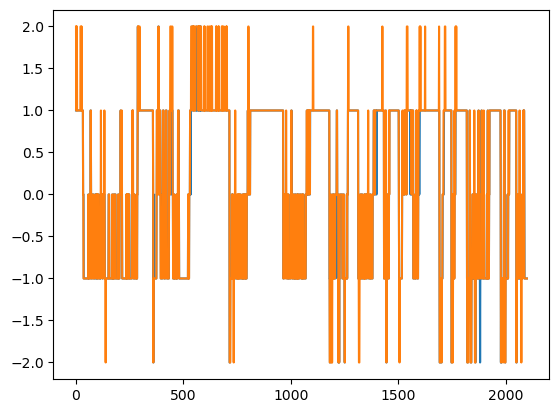

In [149]:
plt.plot(n.round(shx_3d))
plt.plot(n.round(shx_plane))

In [140]:
shxm = sh2xs - sh2xs.mean(axis=0)

In [141]:
bad_frames = n.concatenate([n.where(n.abs(shxm[:,pidx - 1] - shxm[:,pidx]) > 0.5)[0], n.where(n.abs(shxm[:,pidx - + 1] - shxm[:,pidx]) > 0.5)[0]])

In [142]:
diff_frames = n.where(n.abs(shxm[:,pidx] - shx_3d) > 0.5)

In [150]:
from suite3d import reference_image as ref

from suite3d import reg_3d 

sum = job2d.load_summary()

sigma = 1.45, 1.5 # job.params['sigma_reference']
ref_img = sum['ref_img_3d'].copy()
ypad = sum['ypad']
xpad = sum['xpad']
mask_mul, mask_offset = ref.compute_masks3D(ref_img, sigma)
ref_2ds = reg_3d.mask_filter_fft_ref(ref_img, mask_mul, mask_offset, smooth=0.5)
reference_params = sum['reference_params']
rmins = reference_params.get("plane_mins", None)
rmaxs = reference_params.get("plane_maxs", None)


In [151]:
mx = dmov2d[pidx,:nt]
mx = mx.compute()

In [152]:
# phase_corr, int_shifts, phase_corr_peak_locs, float_shifts, __ = reg_3d.rigid_3d_ref_gpu(mx, mask_mul, mask_offset, ref_2ds, pc_size=n.array((5,20,20)), 
#                        rmins = rmins, rmaxs=rmaxs,process_mov=False, shift_reg=False)
phase_corr2d, int_shifts2d, phase_corr_peak_locs2d, float_shifts2d, reg_ret_2d = reg_3d.rigid_3d_ref_gpu(mx[n.newaxis], mask_mul[pidx:pidx+1], mask_offset[pidx:pidx+1], ref_2ds[pidx:pidx+1], pc_size=n.array((0,20,20)), 
                       rmins = rmins, rmaxs=rmaxs,process_mov=False, shift_reg=False)

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f3bd706bd60>)

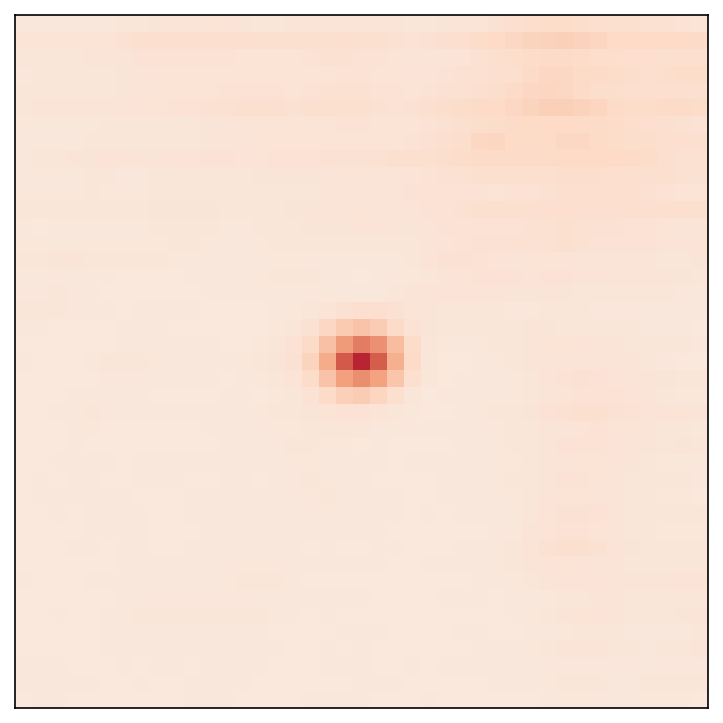

In [153]:
tfu.show_tif(phase_corr2d.mean(axis=0)[0], vminmax=(-0.005,0.005),cmap='RdBu_r')

In [158]:
sum = job3d.load_summary()
z0, z1 = (0,9)

sigma = 1.45, 0.5 # job.params['sigma_reference']
ref_img = sum['ref_img_3d'].copy()[z0:z1]
ref_img_norm = ref_img / ref_img.mean(axis=(1,2), keepdims=True)
mask_mul, mask_offset = ref.compute_masks3D(ref_img_norm, sigma)
ref_2ds = reg_3d.mask_filter_fft_ref(ref_img_norm, mask_mul, mask_offset, smooth=0.5)
reference_params = sum['reference_params']
rmins = reference_params.get("plane_mins", None)
rmaxs = reference_params.get("plane_maxs", None)

In [160]:

mx3 = dmov3d[z0:z1,:nt].compute()

In [161]:
# phase_corr, int_shifts, phase_corr_peak_locs, float_shifts, __ = reg_3d.rigid_3d_ref_gpu(mx, mask_mul, mask_offset, ref_2ds, pc_size=n.array((5,20,20)), 
#                        rmins = rmins, rmaxs=rmaxs,process_mov=False, shift_reg=False)

phase_corr3d, int_shifts3d, phase_corr_peak_locs3d, float_shifts3d, reg_ret_3d = reg_3d.rigid_3d_ref_gpu(mx3[:,:], mask_mul, mask_offset, ref_2ds, pc_size=n.array((2,20,20)), 
                       rmins = rmins, rmaxs=rmaxs,process_mov=False, shift_reg=False)

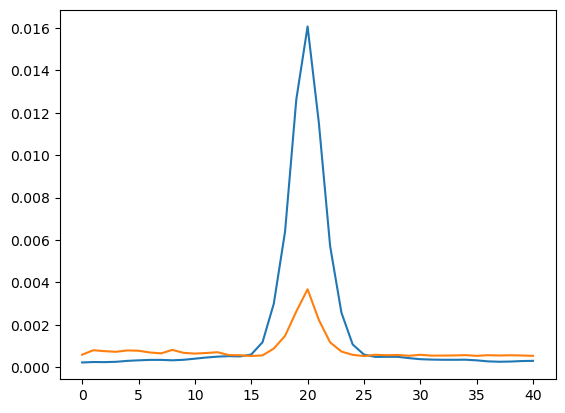

In [172]:
plt.plot(phase_corr3d[diff_frames][:,2].mean(axis=0)[:,20])
plt.plot(phase_corr2d[diff_frames][:,0].mean(axis=0)[:,20])

In [168]:
def maxmin(xs):
    xx = xs / xs.max()
    xx = xx - xx.min()
    return xx

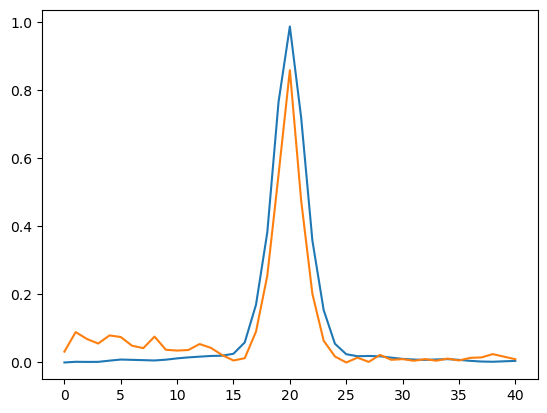

In [171]:
plt.plot(maxmin(phase_corr3d[bad_frames][:,2].mean(axis=0)[:,20]))
plt.plot(maxmin(phase_corr2d[bad_frames][:,0].mean(axis=0)[:,20]))

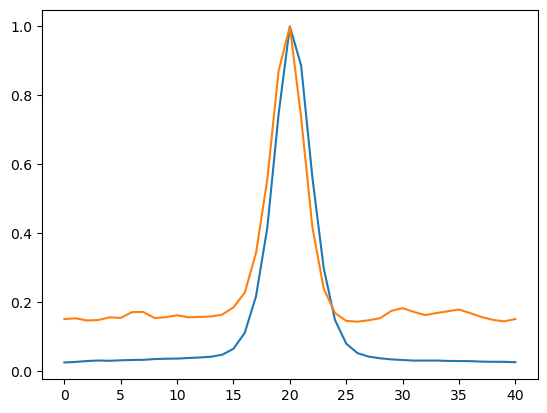

In [162]:
plt.plot(phase_corr3d[diff_frames][:,2].mean(axis=0)[20] / ((phase_corr3d[diff_frames][:,2].mean(axis=0)[20])).max())
plt.plot(phase_corr2d[diff_frames][:,0].mean(axis=0)[20] / ((phase_corr2d[diff_frames][:,0].mean(axis=0)[20])).max())

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f3bd6ed8be0>)

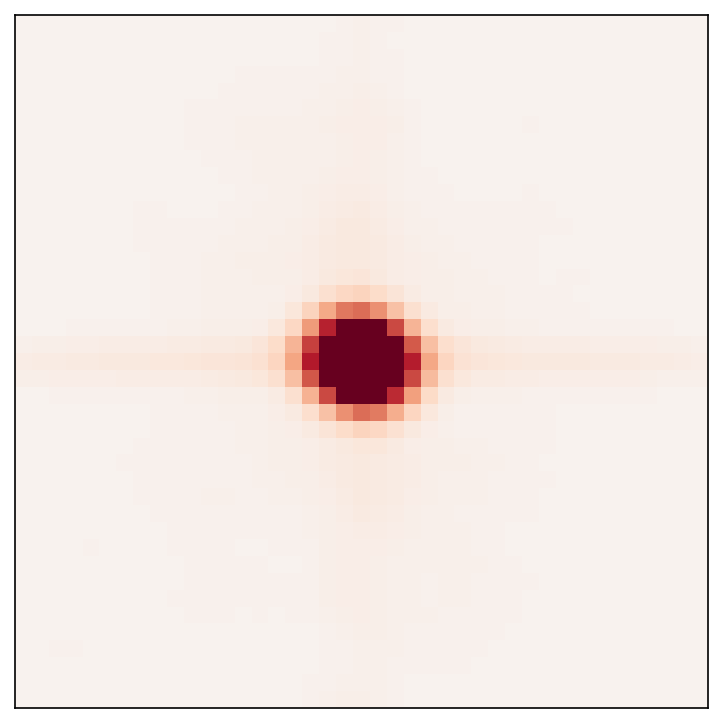

In [163]:
tfu.show_tif(phase_corr3d.mean(axis=0)[2], vminmax=(-0.005,0.005),cmap='RdBu_r')

In [102]:
cmat = n.corrcoef(n.concatenate([shxm.T, [shx_3d]]))

In [103]:
((shxm[:,pidx] - shxm[:,pidx + 1])**2).mean()

0.07660114

In [104]:
(((shxm[:,pidx+1] - n.median(shxm[:,pidx+1])) - (shxm[:,pidx] - n.median(shxm[:,pidx])))**2).mean()

0.07666667

In [105]:
(((shxm[:,pidx] - n.median(shxm[:,pidx])) - (shx_3d - n.median(shx_3d)))**2).mean()

1.0066666666666666

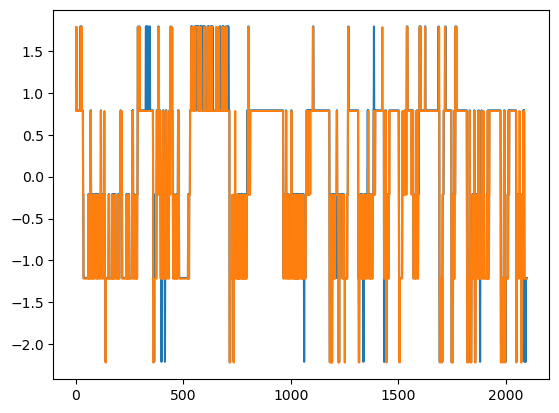

In [106]:

plt.plot(shxm[:,pidx])
plt.plot(shxm[:,pidx+1])

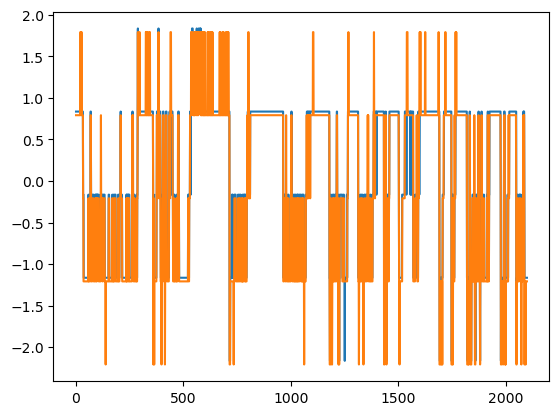

In [107]:
plt.plot(shx_3d)
plt.plot(shxm[:,pidx])

In [179]:
sh2x = sh2xs[:,pidx]
sh2y = sh2ys[:,pidx]

In [180]:
# plt.plot(sh2x - n.median(sh2x), label='2d')
# plt.plot(sh3x - n.median(sh3x)-1, label='3d')
# plt.legend()

In [189]:
im3 = mov3.mean(axis=0)
im3 = im3 / im3.mean()
im2 = mov2.mean(axis=0)
im2 = im2 / im2.mean()

In [190]:
from scipy import signal

In [191]:
corr3 = signal.correlate2d(im3,im3)
corr2 = signal.correlate2d(im2,im2)

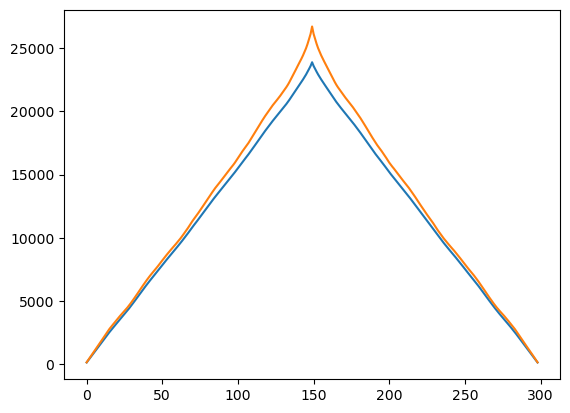

In [193]:
plt.plot(corr3[149])
plt.plot(corr2[149])

(<Figure size 450x450 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f149e0b9220>)

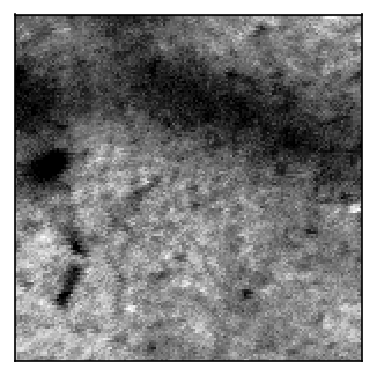

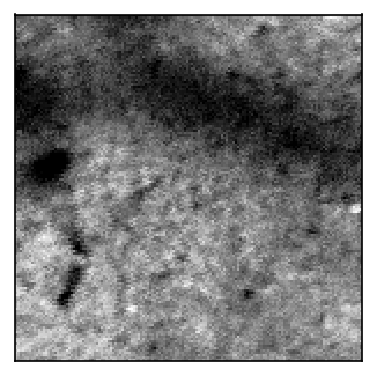

In [185]:
tfu.show_tif(im3, figsize=(3,3), vminmax_percentile=(1,99.99))
tfu.show_tif(im2, figsize=(3,3), vminmax_percentile=(1,99.99))

(<Figure size 450x450 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f149e0103d0>)

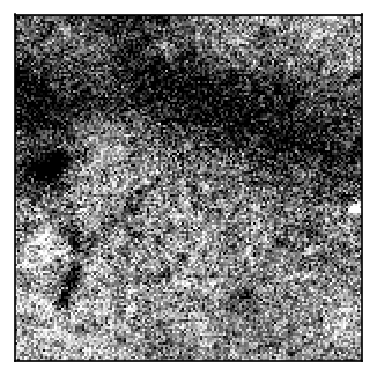

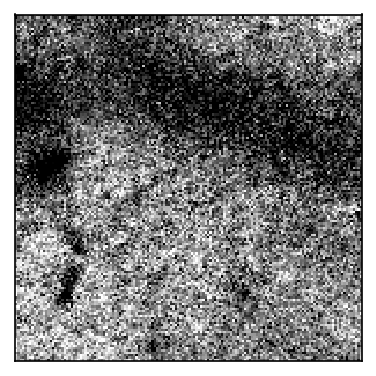

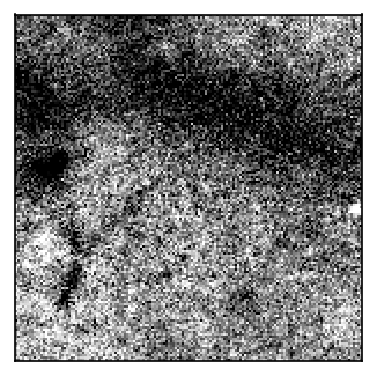

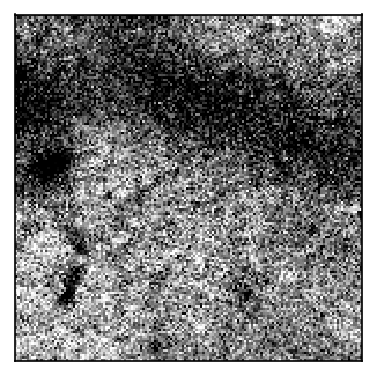

In [186]:
ta = (100, 250)
tb = (550, 700)
im2a = mov2[ta[0]:ta[1]].mean(axis=0)
im2b = mov2[tb[0]:tb[1]].mean(axis=0)
im3a = mov3[ta[0]:ta[1]].mean(axis=0)
im3b = mov3[tb[0]:tb[1]].mean(axis=0)

tfu.show_tif(im3a, cmap='Greys_r',  figsize=(3,3), vminmax_percentile=(10,99))
tfu.show_tif(im3b, cmap='Greys_r',  figsize=(3,3), vminmax_percentile=(10,99))
tfu.show_tif(im2a, cmap='Greys_r',  figsize=(3,3), vminmax_percentile=(10,99))
tfu.show_tif(im2b, cmap='Greys_r',  figsize=(3,3), vminmax_percentile=(10,99))

In [76]:
img3d = job3d.load_summary()['ref_img_3d']

In [87]:
m3f = mov3.reshape(nt, -1)
m2f = mov2.reshape(nt, -1)

In [88]:
m3f.shape

(1000, 22500)

In [90]:
from sklearn.decomposition import PCA

In [91]:
pca3 = PCA(n_components = 99)
pc3f = pca3.fit_transform(m3f)
comp3 = pca3.components_.reshape(-1, *mov3[0].shape)

pca2 = PCA(n_components = 99)
pc2f = pca2.fit_transform(m2f)
comp2 = pca2.components_.reshape(-1, *mov2[0].shape)

In [92]:
nfr = 50

(<Figure size 450x450 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f149f1e6d60>)

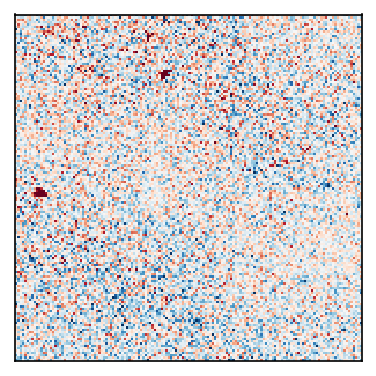

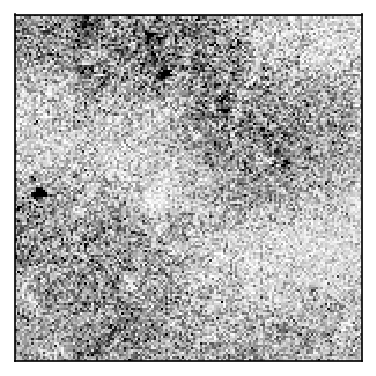

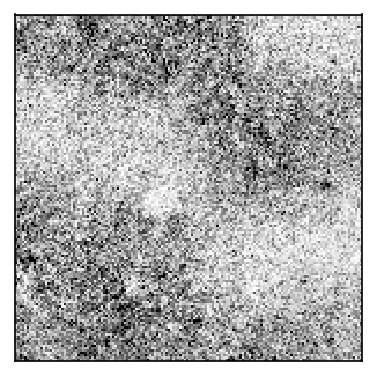

In [93]:
pcidx = 0
sort_tidxs = n.argsort(pc3f[:,pcidx])
tops = mov3[sort_tidxs[-nfr:]].mean(axis=0)
bots = mov3[sort_tidxs[:nfr]].mean(axis=0)
difmax = n.percentile(n.abs(tops - bots),99.5)
tfu.show_tif(tops - bots, cmap='RdBu_r', vminmax=(-difmax,difmax), figsize=(3,3))
tfu.show_tif(tops, cmap='Greys', figsize=(3,3), vminmax_percentile=(1,99))
tfu.show_tif(bots, cmap='Greys', figsize=(3,3), vminmax_percentile=(1,99))


(<Figure size 450x450 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f149f0aa460>)

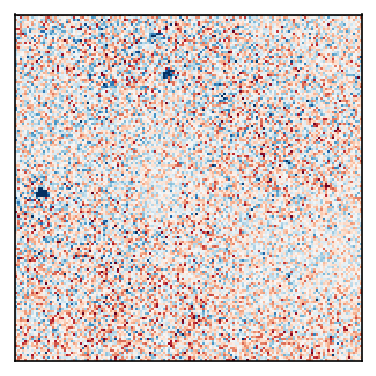

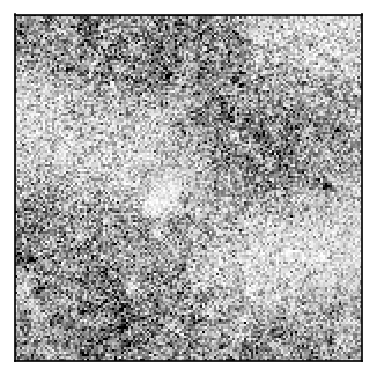

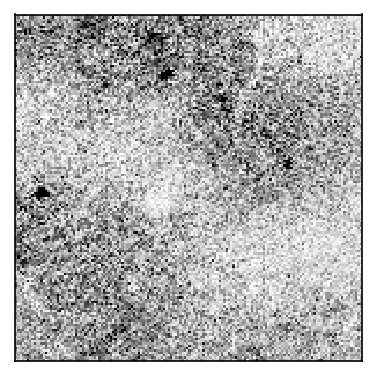

In [94]:
pcidx = 0
sort_tidxs = n.argsort(pc2f[:,pcidx])
tops = mov2[sort_tidxs[-nfr:]].mean(axis=0)
bots = mov2[sort_tidxs[:nfr]].mean(axis=0)
difmax = n.percentile(n.abs(tops - bots),99.5)
tfu.show_tif(tops - bots, cmap='RdBu_r', vminmax=(-difmax,difmax), figsize=(3,3))
tfu.show_tif(tops, cmap='Greys', figsize=(3,3), vminmax_percentile=(1,99))
tfu.show_tif(bots, cmap='Greys', figsize=(3,3), vminmax_percentile=(1,99))


In [ ]:
for i in range(10):
    tfu.show_tif(comp2[i], figsize=(3,3), cmap='RdBu_r', vminmax=(-0.1,0.1))

In [ ]:
for i in range(10):
    tfu.show_tif(comp3[i], figsize=(3,3), cmap='RdBu_r', vminmax=(-0.1,0.1))

In [ ]:
(8, 444, 420)